In [11]:
import matplotlib.pyplot as plt
from PIL import Image
import random
import os
from torchvision import transforms
import os
from sklearn.metrics import accuracy_score,f1_score
from tqdm import tqdm
import torch
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils.data import DataLoader,random_split,Subset
from transformers import AutoImageProcessor, ViTForImageClassification,AdamW

In [12]:
# Define preprocessing transformations
image_processor = AutoImageProcessor.from_pretrained("google/vit-base-patch16-224")
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 224x224
    transforms.ToTensor(),          # Convert images to tensor
    transforms.Normalize(mean=image_processor.image_mean, std=image_processor.image_std)
])

# Load dataset
dataset_original = ImageFolder(root="./dataset/data", transform=transform)
dataset_augment = ImageFolder(root="./VietNameseAncient", transform=transform)


In [13]:
from collections import Counter
label_counts_out = Counter(dataset_augment.targets)
label_counts = Counter(dataset_original.targets)
classes = dataset_augment.classes
for class_idx, class_name in enumerate(classes):
    print("="*20)
    print(f"Lớp '{class_name}' ban đầu: {label_counts[class_idx]} ảnh")
    print(f"Lớp '{class_name}' bổ sung: {label_counts_out[class_idx]} ảnh")
    print(f"Số lượng ảnh được bổ sung của lớp '{class_name}' {label_counts_out[class_idx]-label_counts[class_idx]}:")
    print("="*20)

Lớp 'id_01_thong_thuong' ban đầu: 4462 ảnh
Lớp 'id_01_thong_thuong' bổ sung: 11260 ảnh
Số lượng ảnh được bổ sung của lớp 'id_01_thong_thuong' 6798:
Lớp 'id_02_hanh_chinh' ban đầu: 1046 ảnh
Lớp 'id_02_hanh_chinh' bổ sung: 6523 ảnh
Số lượng ảnh được bổ sung của lớp 'id_02_hanh_chinh' 5477:
Lớp 'id_03_ngoai_canh' ban đầu: 6358 ảnh
Lớp 'id_03_ngoai_canh' bổ sung: 11594 ảnh
Số lượng ảnh được bổ sung của lớp 'id_03_ngoai_canh' 5236:


In [14]:
# Đường dẫn tới model đã lưu
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_path = "./models/best_model"
model = ViTForImageClassification.from_pretrained(model_path)
model.to(device)
model.eval()

# Đường dẫn thư mục VietNameseAncient
base_dir = "VietNameseAncient"
categories = ["id_01_thong_thuong", "id_02_hanh_chinh", "id_03_ngoai_canh"]
image_processor = AutoImageProcessor.from_pretrained("google/vit-base-patch16-224")
# Hàm dự đoán ảnh
def predict_image(image_path, model):
    image = Image.open(image_path).convert("RGB")
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=image_processor.image_mean, std=image_processor.image_std)
    ])
    input_tensor = transform(image).unsqueeze(0).to(device)
    with torch.no_grad():
        outputs = model(pixel_values=input_tensor)
        probabilities = torch.softmax(outputs.logits, dim=-1)
        prediction = torch.argmax(probabilities, dim=-1).item()
    return prediction, probabilities.cpu().numpy()


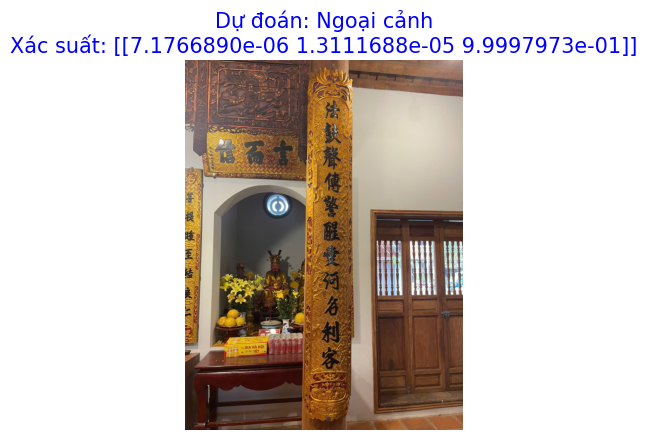

Prediction (label): 2
Probabilities: [[7.1766890e-06 1.3111688e-05 9.9997973e-01]]
Predicted class name: Ngoại cảnh


In [15]:
import matplotlib.pyplot as plt
from PIL import Image
class_name = {0: "Thông thường", 1: "Hành chính", 2: "Ngoại cảnh"}

# ======================
# CHẠY ĐỂ TEST 1 ẢNH
# ======================
def test_single_image():
    # Nhập đường dẫn ảnh
    image_path = input("Nhập đường dẫn ảnh (ví dụ: ./12.jpg): ")
    
    # Thực hiện dự đoán
    prediction, probabilities = predict_image(image_path, model)
    
    # Mở và hiển thị ảnh
    image = Image.open(image_path)
    plt.imshow(image)
    plt.axis("off")
    
    # Hiển thị kết quả dự đoán
    plt.title(
        f"Dự đoán: {class_name[prediction]}\n"
        f"Xác suất: {probabilities}", 
        fontsize=15, 
        color="blue"
    )
    plt.show()

    # In ra màn hình console chi tiết
    print("Prediction (label):", prediction)
    print("Probabilities:", probabilities)
    print("Predicted class name:", class_name[prediction])

# Gọi hàm để test
if __name__ == "__main__":
    test_single_image()
